## 1. Imports & Setup

In [85]:
# TensorFlow/Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization, Activation

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# Scikit-learn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# Set seeds
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow: {tf.__version__}")

TensorFlow: 2.15.0


## 2. Configuration

In [86]:
# Parameters
DATA_PATH = '../data/5s_data/eth_orderbook_coinbase_5s_with_price_volume.csv'
LOOKAHEAD_STEPS = 180  # 15 minutes at 5-second intervals
SEQUENCE_LENGTH = 100  # 100 steps = 500 seconds lookback

# Triple Barrier
TAKE_PROFIT_PCT = 0.002  # +0.2%
STOP_LOSS_PCT = 0.002    # -0.2%

# Feature Configuration
MAX_ORDERBOOK_DEPTH = 10  # Include orderbook levels 1-4 (set 1-10)
USE_MICROSTRUCTURE_FEATURES = True  # Include log_ret, volume, spread, OFI

print(f"Lookahead: {LOOKAHEAD_STEPS} steps = {LOOKAHEAD_STEPS * 5 / 60:.1f} min")
print(f"Sequence: {SEQUENCE_LENGTH} steps = {SEQUENCE_LENGTH * 5} seconds")
print(f"Take Profit: +{TAKE_PROFIT_PCT*100:.1f}%, Stop Loss: -{STOP_LOSS_PCT*100:.1f}%")
print(f"Orderbook Depth: {MAX_ORDERBOOK_DEPTH} levels")
print(f"Microstructure Features: {'Enabled' if USE_MICROSTRUCTURE_FEATURES else 'Disabled'}")

Lookahead: 180 steps = 15.0 min
Sequence: 100 steps = 500 seconds
Take Profit: +0.2%, Stop Loss: -0.2%
Orderbook Depth: 10 levels
Microstructure Features: Enabled


## 3. Load Data

In [87]:
# Load CSV
print(f"Loading data from {DATA_PATH}...")
df = pd.read_csv(DATA_PATH)
print(f"Data shape: {df.shape}")

Loading data from ../data/5s_data/eth_orderbook_coinbase_5s_with_price_volume.csv...
Data shape: (276300, 43)


In [88]:
# Convert timestamp (assume data is already sorted chronologically)
df['timestamp'] = pd.to_datetime(df['timestamp'])

print(f"\nData shape: {df.shape}")
print(f"Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")

# Check if we have enough data
min_required = LOOKAHEAD_STEPS + SEQUENCE_LENGTH + 100  # ~400 rows minimum
if len(df) < min_required:
    print(f"\n⚠️  WARNING: Insufficient data!")
    print(f"   Current rows: {len(df)}")
    print(f"   Minimum required: ~{min_required}")
    print(f"   Need at least {LOOKAHEAD_STEPS} (lookahead) + {SEQUENCE_LENGTH} (sequence) + buffer")
    print(f"\n   This CSV appears to be a sample/test file.")
    print(f"   Please use a larger dataset for training.")

print(f"\nColumns: {list(df.columns)}")
print(f"\nFirst few rows:")
df.head()


Data shape: (276300, 43)
Date range: 2025-12-01 02:57:15.727819 to 2025-12-18 22:05:26.176962

Columns: ['timestamp', 'bid_price_1', 'bid_vol_1', 'ask_price_1', 'ask_vol_1', 'bid_price_2', 'bid_vol_2', 'ask_price_2', 'ask_vol_2', 'bid_price_3', 'bid_vol_3', 'ask_price_3', 'ask_vol_3', 'bid_price_4', 'bid_vol_4', 'ask_price_4', 'ask_vol_4', 'bid_price_5', 'bid_vol_5', 'ask_price_5', 'ask_vol_5', 'bid_price_6', 'bid_vol_6', 'ask_price_6', 'ask_vol_6', 'bid_price_7', 'bid_vol_7', 'ask_price_7', 'ask_vol_7', 'bid_price_8', 'bid_vol_8', 'ask_price_8', 'ask_vol_8', 'bid_price_9', 'bid_vol_9', 'ask_price_9', 'ask_vol_9', 'bid_price_10', 'bid_vol_10', 'ask_price_10', 'ask_vol_10', 'price', 'volume']

First few rows:


,timestamp,bid_price_1,bid_vol_1,ask_price_1,ask_vol_1,bid_price_2,bid_vol_2,ask_price_2,ask_vol_2,bid_price_3,...,bid_price_9,bid_vol_9,ask_price_9,ask_vol_9,bid_price_10,bid_vol_10,ask_price_10,ask_vol_10,price,volume
0,2025-12-01 02:57:15.727819,2841.16,0.042627,2841.17,0.017375,2841.10,0.114237,2841.27,0.175978,2841.09,...,2840.81,0.529741,2841.81,0.050,2840.80,0.072000,2841.82,0.458657,2841.165,0.597915
1,2025-12-01 02:57:21.073133,2841.10,0.000496,2841.11,0.067460,2841.09,0.201554,2841.16,0.175985,2841.08,...,2840.69,0.517682,2841.55,0.001,2840.60,0.851290,2841.66,0.050000,2841.085,0.777114
2,2025-12-01 02:57:26.375175,2840.82,0.000882,2841.00,0.067460,2840.81,0.042241,2841.17,0.029813,2840.80,...,2840.55,1.807218,2841.41,0.050,2840.54,0.500000,2841.42,0.099998,2840.990,1.177497
3,2025-12-01 02:57:31.660663,2841.00,0.068000,2841.01,0.054060,2840.91,0.043133,2841.29,0.035200,2840.90,...,2840.60,0.068000,2841.72,0.001,2840.54,0.437317,2841.73,1.341443,2841.005,0.025164
4,2025-12-01 02:57:37.007031,2841.00,0.069421,2841.01,0.047244,2840.90,0.110240,2841.22,0.000891,2840.84,...,2840.60,0.068000,2841.54,0.512,2840.55,0.437316,2841.55,0.001000,2841.005,0.003338


## 4. Calculate Mid-Price

Mid-Price Stats:
count    276300.000000
mean       3066.920414
std         145.398315
min        2719.245000
25%        2957.215000
50%        3089.955000
75%        3150.605000
max        3447.540000
Name: mid_price, dtype: float64


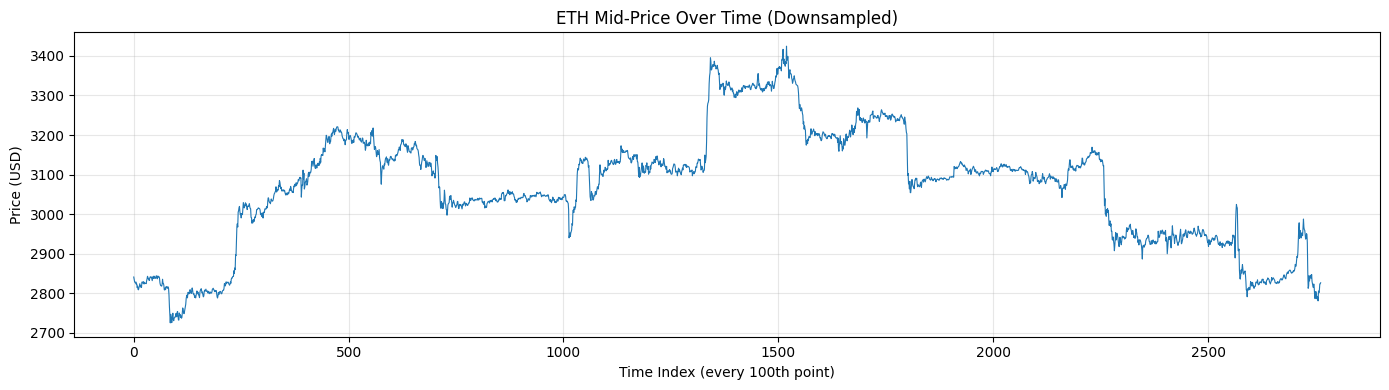

In [89]:
# Calculate mid-price
df['mid_price'] = (df['bid_price_1'] + df['ask_price_1']) / 2.0

print(f"Mid-Price Stats:")
print(df['mid_price'].describe())

# Quick visualization
plt.figure(figsize=(14, 4))
plt.plot(df['mid_price'].values[::100], linewidth=0.8)
plt.title('ETH Mid-Price Over Time (Downsampled)')
plt.xlabel('Time Index (every 100th point)')
plt.ylabel('Price (USD)')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Calculate Rolling Volatility

**Strategy:** Use rolling volatility to make dynamic thresholds that adapt to market conditions.

In [90]:
# Calculate returns and rolling volatility (ATR proxy for snapshots)
df['returns'] = df['mid_price'].pct_change()

# Rolling window of 100 steps (approx 8-10 minutes) to estimate current volatility
df['volatility'] = df['returns'].rolling(window=100).std()

# Fill NaNs (for the first 100 rows) with the mean volatility to avoid errors
df['volatility'] = df['volatility'].fillna(df['volatility'].mean())

# Quick check of what our new targets look like
print(f"Mean Volatility (5s): {df['volatility'].mean():.6f}")
print(f"Dynamic Target (0.5 * Vol): {0.5 * df['volatility'].mean():.6f}")
print(f"Dynamic Target (1.0 * Vol): {1.0 * df['volatility'].mean():.6f}")

print(f"\nVolatility Statistics:")
print(df['volatility'].describe())

Mean Volatility (5s): 0.000247


Dynamic Target (0.5 * Vol): 0.000123
Dynamic Target (1.0 * Vol): 0.000247

Volatility Statistics:
count    276300.000000
mean          0.000247
std           0.000248
min           0.000022
25%           0.000140
50%           0.000195
75%           0.000290
max           0.008345
Name: volatility, dtype: float64


## 6. Fixed Triple Barrier Labeling

**Using configuration thresholds:**

- **Upper Barrier:** Price × (1 + TAKE_PROFIT_PCT)
- **Lower Barrier:** Price × (1 - STOP_LOSS_PCT)
- **Lookahead:** Check within LOOKAHEAD_STEPS

In [91]:
import numpy as np

def label_triple_barrier_fixed(prices, lookahead, take_profit_pct, stop_loss_pct):
    """
    Fixed Triple Barrier Method - Uses configuration parameters directly.
    - Label 1 (BUY): Hit upper barrier (Price + take_profit_pct) first
    - Label -1 (SELL): Hit lower barrier (Price - stop_loss_pct) first
    - Label 0 (HOLD): Hit neither within lookahead period
    """
    n = len(prices)
    labels = np.full(n, np.nan)
    
    print(f"Applying Fixed Triple Barrier Method...")
    print(f"  Take Profit: +{take_profit_pct*100:.2f}%")
    print(f"  Stop Loss: -{stop_loss_pct*100:.2f}%")
    print(f"  Lookahead: {lookahead} steps\n")
    
    for i in tqdm(range(n - lookahead)):
        current_price = prices[i]
        
        # Fixed thresholds from configuration
        upper_barrier = current_price * (1 + take_profit_pct)
        lower_barrier = current_price * (1 - stop_loss_pct)
        
        # Look ahead
        future_prices = prices[i+1:i+1+lookahead]
        
        # Check which barrier is hit first
        hit_tp = np.where(future_prices >= upper_barrier)[0]
        hit_sl = np.where(future_prices <= lower_barrier)[0]
        
        if len(hit_tp) > 0 and len(hit_sl) > 0:
            if hit_tp[0] < hit_sl[0]:
                labels[i] = 1  # BUY
            else:
                labels[i] = -1  # SELL
        elif len(hit_tp) > 0:
            labels[i] = 1  # BUY
        elif len(hit_sl) > 0:
            labels[i] = -1  # SELL
        else:
            labels[i] = 0  # HOLD
            
    return labels

# Apply labeling using configuration parameters
df['label'] = label_triple_barrier_fixed(
    df['mid_price'].values,
    lookahead=LOOKAHEAD_STEPS,
    take_profit_pct=TAKE_PROFIT_PCT,
    stop_loss_pct=STOP_LOSS_PCT
)

print(f"\nLabeling complete!")
print(f"\nLabel distribution (Fixed Triple Barrier):")
label_counts = df['label'].value_counts().sort_index()
for label, count in label_counts.items():
    if np.isnan(label):
        print(f"  NaN: {count:7d}")
    else:
        label_name = ['SELL', 'HOLD', 'BUY'][int(label) + 1]
        print(f"  {label_name:4s} ({int(label):2d}): {count:7d}")

Applying Fixed Triple Barrier Method...
  Take Profit: +0.20%
  Stop Loss: -0.20%
  Lookahead: 180 steps



100%|██████████| 276120/276120 [00:00<00:00, 408124.79it/s]


Labeling complete!

Label distribution (Fixed Triple Barrier):
  SELL (-1):   99310
  HOLD ( 0):   76277
  BUY  ( 1):  100533


## 7. Drop Hold Labels (Label 0)

**Strategy:** Remove neutral/timeout cases to force the model to learn only actionable setups.

In [92]:
# Filter: Keep only BUY (1) and SELL (-1) labels
print(f"Before filtering: {len(df)} rows")

df = df[~df['label'].isna() & (df['label'] != 0)].copy()
df = df.reset_index(drop=True)

print(f"After filtering: {len(df)} rows")
print(f"\nFinal label distribution:")
label_counts = df['label'].value_counts().sort_index()
for label, count in label_counts.items():
    label_name = 'SELL' if label == -1 else 'BUY'
    pct = 100 * count / len(df)
    print(f"  {label_name:4s} ({int(label):2d}): {count:7d} ({pct:.2f}%)")

Before filtering: 276300 rows
After filtering: 199843 rows

Final label distribution:
  SELL (-1):   99310 (49.69%)
  BUY  ( 1):  100533 (50.31%)


## 8. Feature Engineering (Financial Time Series Approach)

**Strategy:** Transform features to be stationary and robust to outliers (whales).

**Key Improvements:**
1. **Log Returns** - Stationary, symmetric, additive (ETH & BTC)
2. **Log Volume Change** - Handles volume spikes (ETH & BTC)
3. **Relative Spread** - Normalized by price
4. **Log-Transformed Depth** - Squashes whale orders
5. **RobustScaler** - Uses median/IQR instead of mean/std

In [ ]:
# 1. Momentum & Price Features
# Log returns are additive and symmetric -- better for ML than simple % change
df['log_ret'] = np.log(df['mid_price'] / df['mid_price'].shift(1))

# 2. Trade Volume Features (from actual trades, not order book)
# Log-transform trade volume change
df['log_trade_vol'] = np.log1p(df['volume'])  # Absolute trade volume
df['log_trade_vol_change'] = df['log_trade_vol'] - df['log_trade_vol'].shift(1)

# 3. BTC Features (macro market indicator)
if 'btc_price' in df.columns and 'btc_volume' in df.columns:
    df['log_btc_ret'] = np.log(df['btc_price'] / df['btc_price'].shift(1))
    df['log_btc_vol'] = np.log1p(df['btc_volume'])
    df['log_btc_vol_change'] = df['log_btc_vol'] - df['log_btc_vol'].shift(1)
    print(f"Added BTC features: log_btc_ret, log_btc_vol_change")
else:
    print("Warning: btc_price/btc_volume columns not found, skipping BTC features")

# 4. Market Structure
df['spread'] = df['ask_price_1'] - df['bid_price_1']
df['rel_spread'] = df['spread'] / df['mid_price']

# 5. Order Flow Imbalance (OFI) - using order book depth
df['bid_vol_1_shift'] = df['bid_vol_1'].shift(1)
df['ask_vol_1_shift'] = df['ask_vol_1'].shift(1)
df['OFI'] = (df['bid_vol_1'] - df['bid_vol_1_shift']) - (df['ask_vol_1'] - df['ask_vol_1_shift'])

# 6. Log-Transform Order Book Depth Volumes (Squash the "Whales")
# Only transform bid/ask volumes (order book depth), NOT trade volume
depth_vol_cols = [c for c in df.columns if ('bid_vol' in c or 'ask_vol' in c) and 'shift' not in c]
print(f"Log-transforming {len(depth_vol_cols)} order book depth columns: {depth_vol_cols[:4]}... (showing first 4)")

for col in depth_vol_cols:
    df[f'log_{col}'] = np.log1p(df[col])  # log1p = log(1 + x) to handle zeros

# Drop temporary shift columns and NaNs
drop_cols = ['bid_vol_1_shift', 'ask_vol_1_shift', 'log_trade_vol']
if 'log_btc_vol' in df.columns:
    drop_cols.append('log_btc_vol')
df = df.drop(columns=drop_cols)
df = df.dropna().reset_index(drop=True)

print(f"\nAfter feature engineering: {len(df)} rows")
print(f"\nKey feature statistics:")
stats_cols = ['log_ret', 'log_trade_vol_change', 'rel_spread', 'OFI']
if 'log_btc_ret' in df.columns:
    stats_cols.extend(['log_btc_ret', 'log_btc_vol_change'])
print(df[stats_cols].describe())

Log-transforming 20 order book depth columns: ['bid_vol_1', 'ask_vol_1', 'bid_vol_2', 'ask_vol_2']... (showing first 4)

After feature engineering: 103119 rows

Key feature statistics:
             log_ret  log_trade_vol_change     rel_spread            OFI
count  103119.000000         103119.000000  103119.000000  103119.000000
mean       -0.000001              0.002466       0.000012       0.003199
std         0.000316              1.180348       0.000028      18.137908
min        -0.005286             -6.907562       0.000003   -1221.534993
25%        -0.000099             -0.629753       0.000003      -0.849459
50%         0.000000              0.000000       0.000003       0.000000
75%         0.000097              0.610110       0.000004       0.836828
max         0.005152              6.475230       0.001016    1223.413862


## 9. Select Features & Labels

In [ ]:
# Dynamically build feature list based on configuration
feature_cols = []

# Add microstructure features if enabled
if USE_MICROSTRUCTURE_FEATURES:
    feature_cols.extend([
        'log_ret',                # Price momentum (stationary)
        'log_trade_vol_change',   # Trade volume momentum  
        'rel_spread',             # Normalized spread
        'OFI'                     # Order flow imbalance
    ])
    
    # Add BTC features if available
    if 'log_btc_ret' in df.columns:
        feature_cols.extend([
            'log_btc_ret',           # BTC price momentum (macro indicator)
            'log_btc_vol_change'     # BTC volume momentum
        ])

# Add orderbook depth features up to MAX_ORDERBOOK_DEPTH
for level in range(1, MAX_ORDERBOOK_DEPTH + 1):
    feature_cols.extend([
        f'log_bid_vol_{level}',
        f'log_ask_vol_{level}'
    ])

X = df[feature_cols].values
y = df['label'].values

print(f"Feature matrix X: {X.shape}")
print(f"Label vector y: {y.shape}")
print(f"\nFeatures ({len(feature_cols)} total):")
for i, feat in enumerate(feature_cols):
    print(f"  {i+1:2d}. {feat}")
    
# Check for any remaining NaNs or Infs
if np.isnan(X).any() or np.isinf(X).any():
    print(f"\n⚠️  WARNING: Found NaN or Inf in features!")
    print(f"   NaN count: {np.isnan(X).sum()}")
    print(f"   Inf count: {np.isinf(X).sum()}")
    X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
    print(f"   ✓ Cleaned")
else:
    print(f"\n✓ No NaN or Inf values")

Feature matrix X: (103119, 24)
Label vector y: (103119,)

Features (24 total):
   1. log_ret
   2. log_trade_vol_change
   3. rel_spread
   4. OFI
   5. log_bid_vol_1
   6. log_ask_vol_1
   7. log_bid_vol_2
   8. log_ask_vol_2
   9. log_bid_vol_3
  10. log_ask_vol_3
  11. log_bid_vol_4
  12. log_ask_vol_4
  13. log_bid_vol_5
  14. log_ask_vol_5
  15. log_bid_vol_6
  16. log_ask_vol_6
  17. log_bid_vol_7
  18. log_ask_vol_7
  19. log_bid_vol_8
  20. log_ask_vol_8
  21. log_bid_vol_9
  22. log_ask_vol_9
  23. log_bid_vol_10
  24. log_ask_vol_10

✓ No NaN or Inf values


## 10. Create Sequences

In [95]:
def create_sequences(X, y, sequence_length):
    """
    Create sliding window sequences.
    
    Returns:
        X_seq: (n_sequences, sequence_length, n_features)
        y_seq: (n_sequences,)
    """
    X_seq, y_seq = [], []
    
    print(f"Creating sequences with length {sequence_length}...")
    for i in tqdm(range(sequence_length, len(X))):
        X_seq.append(X[i - sequence_length:i])
        y_seq.append(y[i])
    
    return np.array(X_seq), np.array(y_seq)

# Create sequences
X_sequences, y_sequences = create_sequences(X, y, SEQUENCE_LENGTH)

print(f"\nSequence shapes:")
print(f"  X_sequences: {X_sequences.shape}  # (n_sequences, sequence_length, n_features)")
print(f"  y_sequences: {y_sequences.shape}  # (n_sequences,)")

Creating sequences with length 100...


100%|██████████| 103019/103019 [00:00<00:00, 3679391.36it/s]



Sequence shapes:
  X_sequences: (103019, 100, 24)  # (n_sequences, sequence_length, n_features)
  y_sequences: (103019,)  # (n_sequences,)


## 11. Train/Val/Test Split (Chronological - 70/15/15)

In [96]:
# 70/15/15 split (chronological - no shuffling!)
train_idx = int(0.70 * len(X_sequences))
val_idx = int(0.85 * len(X_sequences))  # 70% + 15% = 85%

X_train = X_sequences[:train_idx]
y_train = y_sequences[:train_idx]

X_val = X_sequences[train_idx:val_idx]
y_val = y_sequences[train_idx:val_idx]

X_test = X_sequences[val_idx:]
y_test = y_sequences[val_idx:]

print(f"Train/Val/Test Split (Chronological):")
print(f"  Train: {X_train.shape[0]:7d} sequences ({100*len(X_train)/len(X_sequences):.1f}%)")
print(f"  Val:   {X_val.shape[0]:7d} sequences ({100*len(X_val)/len(X_sequences):.1f}%)")
print(f"  Test:  {X_test.shape[0]:7d} sequences ({100*len(X_test)/len(X_sequences):.1f}%)")

# Check class distribution in each set
print(f"\nClass distribution:")
for set_name, y_set in [('Train', y_train), ('Val', y_val), ('Test', y_test)]:
    buy_count = (y_set == 1).sum()
    sell_count = (y_set == -1).sum()
    print(f"  {set_name:5s}: BUY={buy_count:6d} ({100*buy_count/len(y_set):.1f}%), SELL={sell_count:6d} ({100*sell_count/len(y_set):.1f}%)")

Train/Val/Test Split (Chronological):
  Train:   72113 sequences (70.0%)
  Val:     15453 sequences (15.0%)
  Test:    15453 sequences (15.0%)

Class distribution:
  Train: BUY= 35758 (49.6%), SELL= 36355 (50.4%)
  Val  : BUY=  7335 (47.5%), SELL=  8118 (52.5%)
  Test : BUY=  8105 (52.4%), SELL=  7348 (47.6%)


## 12. Robust Scaling (Outlier-Resistant)

In [97]:
from sklearn.preprocessing import RobustScaler

# RobustScaler (fit on train only)
scaler = RobustScaler()

# Reshape to 2D, fit, transform, reshape back to 3D
X_train_2d = X_train.reshape(-1, X_train.shape[-1])
scaler.fit(X_train_2d)

X_train_scaled = scaler.transform(X_train_2d).reshape(X_train.shape)
X_val_scaled = scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)

print(f"RobustScaler applied:")
print(f"  Train median: {np.median(X_train_scaled):.6f}, IQR: {np.percentile(X_train_scaled, 75) - np.percentile(X_train_scaled, 25):.6f}")
print(f"  Val median:   {np.median(X_val_scaled):.6f}, IQR: {np.percentile(X_val_scaled, 75) - np.percentile(X_val_scaled, 25):.6f}")
print(f"\n✓ Features scaled using RobustScaler (resistant to outliers)")

RobustScaler applied:
  Train median: 0.000000, IQR: 0.973175
  Val median:   0.023357, IQR: 1.053000

✓ Features scaled using RobustScaler (resistant to outliers)


## 13. Convert Labels to Categorical

In [98]:
# Map labels: -1 -> 0 (SELL), 1 -> 1 (BUY)
# For binary classification with 2 classes
y_train_mapped = ((y_train + 1) / 2).astype(int)  # -1 -> 0, 1 -> 1
y_val_mapped = ((y_val + 1) / 2).astype(int)

y_train_cat = keras.utils.to_categorical(y_train_mapped, num_classes=2)
y_val_cat = keras.utils.to_categorical(y_val_mapped, num_classes=2)

print(f"Labels converted to categorical:")
print(f"  y_train_cat: {y_train_cat.shape}")
print(f"  y_val_cat: {y_val_cat.shape}")
print(f"\nClass distribution in train:")
unique, counts = np.unique(y_train_mapped, return_counts=True)
for cls, cnt in zip(unique, counts):
    cls_name = 'SELL' if cls == 0 else 'BUY'
    print(f"  {cls_name}: {cnt} ({100*cnt/len(y_train_mapped):.1f}%)")

Labels converted to categorical:
  y_train_cat: (72113, 2)
  y_val_cat: (15453, 2)

Class distribution in train:
  SELL: 36355 (50.4%)
  BUY: 35758 (49.6%)


## 14. Build CNN-LSTM Model with Regularization

In [99]:
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, MaxPooling1D, BatchNormalization, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import regularizers

def build_refined_model(sequence_length, n_features, n_classes=2):
    model = Sequential(name="Refined_DeepLOB")
    
    # Use a much smaller L2 (1e-5) so we don't kill the signal
    reg = regularizers.l2(2e-5)
    
    # --- CNN BLOCK (Feature Extraction) ---
    # Reduced filters (64->32) to prevent memorization, but kept layers deep
    model.add(Conv1D(32, 3, padding='same', kernel_regularizer=reg, 
                     input_shape=(sequence_length, n_features)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Conv1D(32, 3, padding='same', kernel_regularizer=reg))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(MaxPooling1D(2))
    model.add(Dropout(0.3)) # Moderate dropout
    
    # --- LSTM BLOCK (Time Context) ---
    model.add(LSTM(64, return_sequences=True, kernel_regularizer=reg))
    model.add(Dropout(0.3))
    
    model.add(LSTM(64, return_sequences=False, kernel_regularizer=reg))
    model.add(Dropout(0.3))
    
    # --- OUTPUT ---
    model.add(Dense(n_classes, activation='softmax'))
    
    # Start with a standard LR, let the scheduler reduce it later
    optimizer = Adam(learning_rate=1e-3) 
    
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model

# --- UPDATED CALLBACKS ---
# This is crucial: If validation loss stalls for 5 epochs, cut LR by 50%
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=12, # Give it time to recover after an LR drop
    restore_best_weights=True,
    verbose=1
)

# Train
model = build_refined_model(SEQUENCE_LENGTH, X_train_scaled.shape[2])
model.summary()

Model: "Refined_DeepLOB"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_9 (Conv1D)           (None, 100, 32)           2336      
                                                                 
 batch_normalization_10 (Ba  (None, 100, 32)           128       
 tchNormalization)                                               
                                                                 
 activation_9 (Activation)   (None, 100, 32)           0         
                                                                 
 conv1d_10 (Conv1D)          (None, 100, 32)           3104      
                                                                 
 batch_normalization_11 (Ba  (None, 100, 32)           128       
 tchNormalization)                                               
                                                                 
 activation_10 (Activation)  (None, 100, 32)       

In [100]:
print("Model with Regularization Built.")
print("Model Architecture:")
print("="*60)
model.summary()
print("="*60)
print(f"Total parameters: {model.count_params():,}")

Model with Regularization Built.
Model Architecture:
Model: "Refined_DeepLOB"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_9 (Conv1D)           (None, 100, 32)           2336      
                                                                 
 batch_normalization_10 (Ba  (None, 100, 32)           128       
 tchNormalization)                                               
                                                                 
 activation_9 (Activation)   (None, 100, 32)           0         
                                                                 
 conv1d_10 (Conv1D)          (None, 100, 32)           3104      
                                                                 
 batch_normalization_11 (Ba  (None, 100, 32)           128       
 tchNormalization)                                               
                                                                

## 15. Train Model

In [101]:
# Callback: Early Stopping
early_stop = EarlyStopping(
    monitor='val_accuracy',  # Monitor accuracy instead of loss
    patience=15,             # Increased patience
    mode='max',              # We want to maximize accuracy
    restore_best_weights=True,
    verbose=1
)

# Training
BATCH_SIZE = 64
EPOCHS = 100  # Increased max epochs

print(f"Training parameters:")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Max epochs: {EPOCHS}")
print(f"  Early stopping patience: 15")
print(f"\nStarting training...\n")

history = model.fit(
    X_train_scaled, y_train_cat,
    validation_data=(X_val_scaled, y_val_cat),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stop],
    verbose=1
)

print("\n" + "="*60)
print("TRAINING COMPLETE")
print("="*60)

Training parameters:
  Batch size: 64
  Max epochs: 100
  Early stopping patience: 15

Starting training...

Epoch 1/100
1127/1127 [==============================] - 26s 21ms/step - loss: 0.6867 - accuracy: 0.5472 - val_loss: 0.7970 - val_accuracy: 0.4996
Epoch 2/100
1127/1127 [==============================] - 23s 20ms/step - loss: 0.6072 - accuracy: 0.6652 - val_loss: 0.8799 - val_accuracy: 0.5057
Epoch 3/100
1127/1127 [==============================] - 23s 20ms/step - loss: 0.4710 - accuracy: 0.7730 - val_loss: 0.9428 - val_accuracy: 0.5208
Epoch 4/100
1127/1127 [==============================] - 23s 20ms/step - loss: 0.3870 - accuracy: 0.8248 - val_loss: 1.1036 - val_accuracy: 0.5446
Epoch 5/100
1127/1127 [==============================] - 23s 20ms/step - loss: 0.3350 - accuracy: 0.8550 - val_loss: 1.1659 - val_accuracy: 0.5275
Epoch 6/100
1127/1127 [==============================] - 23s 20ms/step - loss: 0.3067 - accuracy: 0.8680 - val_loss: 1.2751 - val_accuracy: 0.5120
Epoch 7/1

## 16. Training History

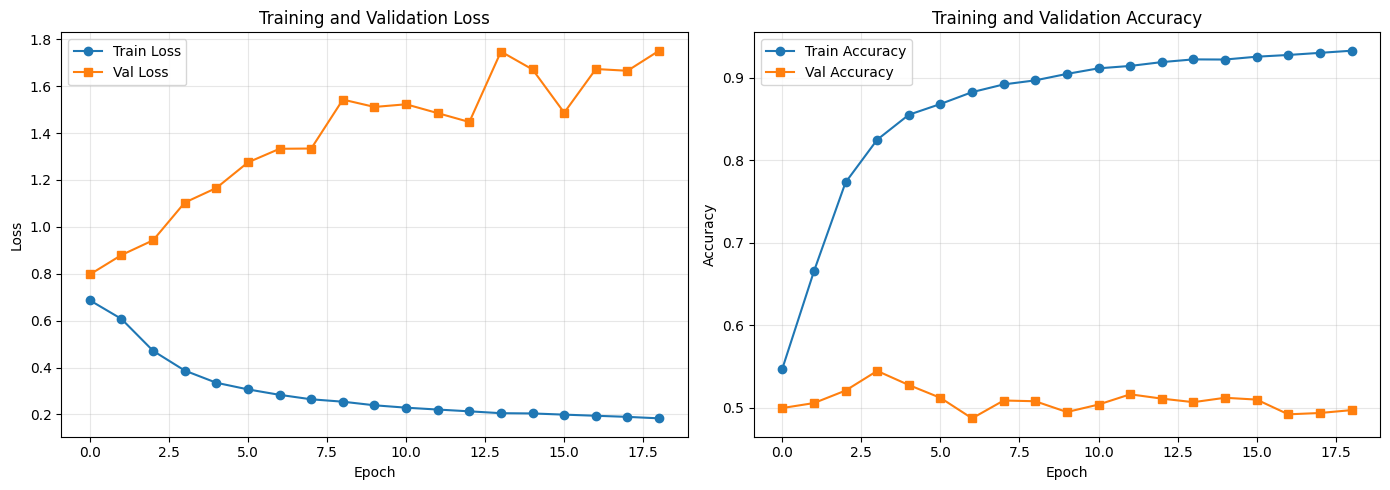

Best epoch: 1
  Val Loss: 0.7970
  Val Accuracy: 0.4996


In [102]:
# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss
axes[0].plot(history.history['loss'], label='Train Loss', marker='o')
axes[0].plot(history.history['val_loss'], label='Val Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Accuracy
axes[1].plot(history.history['accuracy'], label='Train Accuracy', marker='o')
axes[1].plot(history.history['val_accuracy'], label='Val Accuracy', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Best epoch
best_epoch = np.argmin(history.history['val_loss'])
print(f"Best epoch: {best_epoch + 1}")
print(f"  Val Loss: {history.history['val_loss'][best_epoch]:.4f}")
print(f"  Val Accuracy: {history.history['val_accuracy'][best_epoch]:.4f}")

## 17. Evaluate Model

In [103]:
# Evaluate on validation set
print("Evaluating on validation set...\n")
val_loss, val_accuracy = model.evaluate(X_val_scaled, y_val_cat, verbose=0)

print(f"Validation Results:")
print(f"  Loss: {val_loss:.4f}")
print(f"  Accuracy: {val_accuracy:.4f}")

# Get predictions
y_pred_probs = model.predict(X_val_scaled, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_val_cat, axis=1)

print(f"\nPrediction distribution:")
unique, counts = np.unique(y_pred, return_counts=True)
for cls, cnt in zip(unique, counts):
    cls_name = 'SELL' if cls == 0 else 'BUY'
    print(f"  {cls_name}: {cnt} ({100*cnt/len(y_pred):.1f}%)")

Evaluating on validation set...

Validation Results:
  Loss: 1.1036
  Accuracy: 0.5446

Prediction distribution:
  SELL: 12039 (77.9%)
  BUY: 3414 (22.1%)


## 18. Confusion Matrix

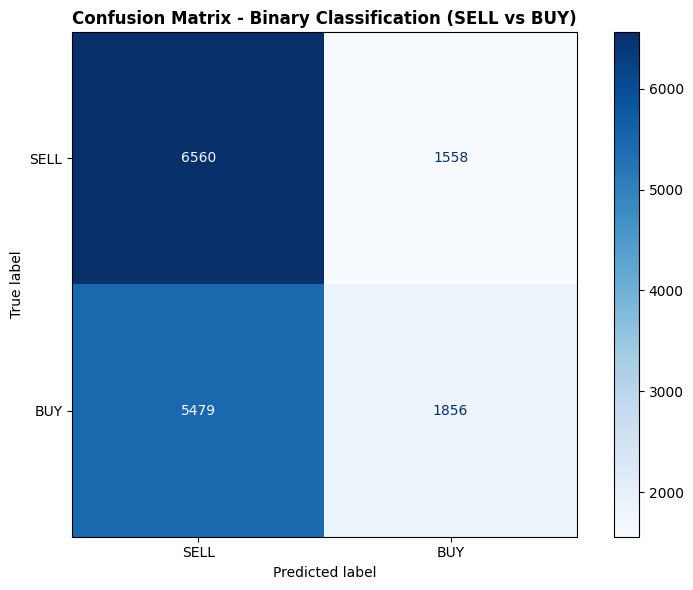


Confusion Matrix:
[[6560 1558]
 [5479 1856]]

Rows = True labels, Cols = Predicted labels


In [104]:
# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)
class_names = ['SELL', 'BUY']

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title('Confusion Matrix - Binary Classification (SELL vs BUY)', fontweight='bold')
plt.tight_layout()
plt.show()

print("\nConfusion Matrix:")
print(cm)
print("\nRows = True labels, Cols = Predicted labels")

## 19. Classification Report

In [105]:
# Detailed classification report
print("="*60)
print("CLASSIFICATION REPORT")
print("="*60)
class_names = ['SELL', 'BUY']
report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
print(report)

# Per-class accuracy
print(f"\nPer-Class Accuracy:")
for i, cls_name in enumerate(class_names):
    mask = y_true == i
    if mask.sum() > 0:
        acc = (y_pred[mask] == i).sum() / mask.sum()
        print(f"  {cls_name:4s}: {acc:.4f}")

CLASSIFICATION REPORT
              precision    recall  f1-score   support

        SELL     0.5449    0.8081    0.6509      8118
         BUY     0.5436    0.2530    0.3453      7335

    accuracy                         0.5446     15453
   macro avg     0.5443    0.5306    0.4981     15453
weighted avg     0.5443    0.5446    0.5059     15453


Per-Class Accuracy:
  SELL: 0.8081
  BUY : 0.2530


## 20. Save Model

In [106]:
# Create models directory if it doesn't exist
import os
import json
os.makedirs('models', exist_ok=True)

# Calculate current model's per-class accuracy
sell_mask = y_true == 0
buy_mask = y_true == 1

current_sell_acc = (y_pred[sell_mask] == 0).sum() / sell_mask.sum() if sell_mask.sum() > 0 else 0
current_buy_acc = (y_pred[buy_mask] == 1).sum() / buy_mask.sum() if buy_mask.sum() > 0 else 0
current_avg_class_acc = (current_sell_acc + current_buy_acc) / 2

print("\n" + "="*60)
print("MODEL SAVING LOGIC")
print("="*60)
print(f"\nCurrent Model Performance:")
print(f"  SELL Accuracy: {current_sell_acc:.4f}")
print(f"  BUY Accuracy:  {current_buy_acc:.4f}")
print(f"  Avg Class Acc: {current_avg_class_acc:.4f}")
print()

# Check if best model exists
best_metrics_path = 'models/best_model_metrics.json'
should_save = False

if os.path.exists(best_metrics_path):
    # Load previous best metrics
    with open(best_metrics_path, 'r') as f:
        best_metrics = json.load(f)
    
    prev_sell_acc = best_metrics.get('sell_accuracy', 0)
    prev_buy_acc = best_metrics.get('buy_accuracy', 0)
    prev_avg_acc = best_metrics.get('avg_class_accuracy', 0)
    
    print(f"Previous Best Model Performance:")
    print(f"  SELL Accuracy: {prev_sell_acc:.4f}")
    print(f"  BUY Accuracy:  {prev_buy_acc:.4f}")
    print(f"  Avg Class Acc: {prev_avg_acc:.4f}")
    print()
    
    # Check if current model is better (using average of both class accuracies)
    if current_avg_class_acc > prev_avg_acc:
        should_save = True
        improvement = (current_avg_class_acc - prev_avg_acc) * 100
        print(f"✓ NEW BEST MODEL! Improvement: +{improvement:.2f}%")
    else:
        decline = (prev_avg_acc - current_avg_class_acc) * 100
        print(f"✗ Not saving. Current model is {decline:.2f}% worse than best.")
else:
    # No previous model exists
    should_save = True
    print("No previous best model found. Saving current model as best.")

print()

if should_save:
    # Save model
    model.save('models/best_model.keras')
    print("✓ Model saved: models/best_model.keras")
    
    # Save scaler
    import joblib
    joblib.dump(scaler, 'models/best_scaler.pkl')
    print("✓ Scaler saved: models/best_scaler.pkl")
    
    # Save metrics
    metrics = {
        'sell_accuracy': float(current_sell_acc),
        'buy_accuracy': float(current_buy_acc),
        'avg_class_accuracy': float(current_avg_class_acc),
        'overall_accuracy': float(val_accuracy),
        'val_loss': float(val_loss),
        'timestamp': pd.Timestamp.now().isoformat(),
        'lookahead_steps': LOOKAHEAD_STEPS,
        'sequence_length': SEQUENCE_LENGTH,
        'num_classes': 2
    }
    
    with open(best_metrics_path, 'w') as f:
        json.dump(metrics, f, indent=2)
    print("✓ Metrics saved: models/best_model_metrics.json")
    print("\n🎉 Model successfully saved as new best!")
else:
    print("⏭️  Skipping save. Previous model remains as best.")

print("\n" + "="*60)
print("NOTEBOOK COMPLETE")
print("="*60)
print(f"\nCurrent Model Summary:")
print(f"  Architecture: CNN-LSTM Hybrid with L2 Regularization")
print(f"  Features: {len(feature_cols)} orderbook + microstructure features")
print(f"  Labeling: Fixed Triple Barrier (config-based)")
print(f"  Classes: Binary (SELL vs BUY, no HOLD)")
print(f"  Sequence Length: {SEQUENCE_LENGTH} steps")
print(f"  Val Accuracy: {val_accuracy:.4f}")
print(f"  Avg Class Accuracy: {current_avg_class_acc:.4f}")


MODEL SAVING LOGIC

Current Model Performance:
  SELL Accuracy: 0.8081
  BUY Accuracy:  0.2530
  Avg Class Acc: 0.5306

Previous Best Model Performance:
  SELL Accuracy: 0.3944
  BUY Accuracy:  0.7201
  Avg Class Acc: 0.5573

✗ Not saving. Current model is 2.67% worse than best.

⏭️  Skipping save. Previous model remains as best.

NOTEBOOK COMPLETE

Current Model Summary:
  Architecture: CNN-LSTM Hybrid with L2 Regularization
  Features: 24 orderbook + microstructure features
  Labeling: Fixed Triple Barrier (config-based)
  Classes: Binary (SELL vs BUY, no HOLD)
  Sequence Length: 100 steps
  Val Accuracy: 0.5446
  Avg Class Accuracy: 0.5306


## 21. Final Test Set Evaluation

**Evaluate the trained model on the held-out test set (15% of data)**

This is the **true measure** of model performance on unseen future data.

In [107]:
# Scale test set using the same scaler (fitted on train only)
X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

# Convert test labels to categorical
y_test_mapped = ((y_test + 1) / 2).astype(int)
y_test_cat = keras.utils.to_categorical(y_test_mapped, num_classes=2)

print("="*60)
print("TEST SET EVALUATION")
print("="*60)
print(f"\nTest set size: {len(X_test)} sequences\n")

# Evaluate on test set
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test_cat, verbose=0)

print(f"Test Set Results:")
print(f"  Loss: {test_loss:.4f}")
print(f"  Accuracy: {test_accuracy:.4f}")

# Get predictions
y_test_pred_probs = model.predict(X_test_scaled, verbose=0)
y_test_pred = np.argmax(y_test_pred_probs, axis=1)
y_test_true = np.argmax(y_test_cat, axis=1)

print(f"\nPrediction distribution:")
unique, counts = np.unique(y_test_pred, return_counts=True)
for cls, cnt in zip(unique, counts):
    cls_name = 'SELL' if cls == 0 else 'BUY'
    print(f"  {cls_name}: {cnt} ({100*cnt/len(y_test_pred):.1f}%)")

TEST SET EVALUATION

Test set size: 15453 sequences

Test Set Results:
  Loss: 1.0250
  Accuracy: 0.5227

Prediction distribution:
  SELL: 12593 (81.5%)
  BUY: 2860 (18.5%)


## 22. Test Set Confusion Matrix

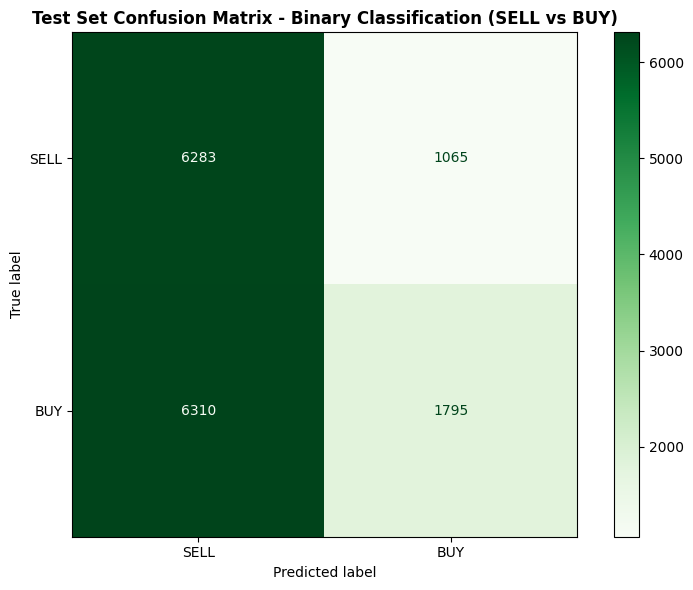


Test Set Confusion Matrix:
[[6283 1065]
 [6310 1795]]

Rows = True labels, Cols = Predicted labels


In [108]:
# Calculate confusion matrix for test set
cm_test = confusion_matrix(y_test_true, y_test_pred)
class_names = ['SELL', 'BUY']

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=class_names)
disp.plot(ax=ax, cmap='Greens', values_format='d')
plt.title('Test Set Confusion Matrix - Binary Classification (SELL vs BUY)', fontweight='bold')
plt.tight_layout()
plt.show()

print("\nTest Set Confusion Matrix:")
print(cm_test)
print("\nRows = True labels, Cols = Predicted labels")

## 23. Test Set Classification Report

In [109]:
# Detailed classification report for test set
print("="*60)
print("TEST SET CLASSIFICATION REPORT")
print("="*60)
class_names = ['SELL', 'BUY']
report_test = classification_report(y_test_true, y_test_pred, target_names=class_names, digits=4)
print(report_test)

# Per-class accuracy
print(f"\nTest Set Per-Class Accuracy:")
test_sell_mask = y_test_true == 0
test_buy_mask = y_test_true == 1

test_sell_acc = (y_test_pred[test_sell_mask] == 0).sum() / test_sell_mask.sum() if test_sell_mask.sum() > 0 else 0
test_buy_acc = (y_test_pred[test_buy_mask] == 1).sum() / test_buy_mask.sum() if test_buy_mask.sum() > 0 else 0
test_avg_class_acc = (test_sell_acc + test_buy_acc) / 2

print(f"  SELL: {test_sell_acc:.4f}")
print(f"  BUY:  {test_buy_acc:.4f}")
print(f"  Avg:  {test_avg_class_acc:.4f}")

TEST SET CLASSIFICATION REPORT
              precision    recall  f1-score   support

        SELL     0.4989    0.8551    0.6302      7348
         BUY     0.6276    0.2215    0.3274      8105

    accuracy                         0.5227     15453
   macro avg     0.5633    0.5383    0.4788     15453
weighted avg     0.5664    0.5227    0.4714     15453


Test Set Per-Class Accuracy:
  SELL: 0.8551
  BUY:  0.2215
  Avg:  0.5383


## 24. Final Summary - All Sets Comparison

In [110]:
print("="*60)
print("FINAL MODEL PERFORMANCE SUMMARY")
print("="*60)

# Create summary table
summary_data = {
    'Dataset': ['Train', 'Validation', 'Test'],
    'Size': [len(X_train), len(X_val), len(X_test)],
    'Accuracy': [
        f"{history.history['accuracy'][-1]:.4f}",
        f"{val_accuracy:.4f}",
        f"{test_accuracy:.4f}"
    ],
    'SELL Acc': [
        'N/A',  # Not calculated during training
        f"{current_sell_acc:.4f}",
        f"{test_sell_acc:.4f}"
    ],
    'BUY Acc': [
        'N/A',
        f"{current_buy_acc:.4f}",
        f"{test_buy_acc:.4f}"
    ]
}

summary_df = pd.DataFrame(summary_data)
print("\n")
print(summary_df.to_string(index=False))

print("\n" + "="*60)
print(f"\n✅ TEST SET PERFORMANCE (UNSEEN DATA):")
print(f"   Overall Accuracy: {test_accuracy:.4f}")
print(f"   Avg Class Accuracy: {test_avg_class_acc:.4f}")
print(f"\n📊 Model Configuration:")
print(f"   Classes: 2 (SELL vs BUY)")
print(f"   Regularization: L2 (λ=0.001) + Dropout (30%)")
print(f"   Take Profit: +{TAKE_PROFIT_PCT*100:.2f}%")
print(f"   Stop Loss: -{STOP_LOSS_PCT*100:.2f}%")
print(f"   Lookahead: {LOOKAHEAD_STEPS} steps ({LOOKAHEAD_STEPS*5/60:.1f} min)")
print(f"   Sequence Length: {SEQUENCE_LENGTH} steps ({SEQUENCE_LENGTH*5} sec)")
print("\n" + "="*60)

FINAL MODEL PERFORMANCE SUMMARY


   Dataset  Size Accuracy SELL Acc BUY Acc
     Train 72113   0.9326      N/A     N/A
Validation 15453   0.5446   0.8081  0.2530
      Test 15453   0.5227   0.8551  0.2215


✅ TEST SET PERFORMANCE (UNSEEN DATA):
   Overall Accuracy: 0.5227
   Avg Class Accuracy: 0.5383

📊 Model Configuration:
   Classes: 2 (SELL vs BUY)
   Regularization: L2 (λ=0.001) + Dropout (30%)
   Take Profit: +0.20%
   Stop Loss: -0.20%
   Lookahead: 180 steps (15.0 min)
   Sequence Length: 100 steps (500 sec)

